### Importing

In [62]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud
import nltk

In [63]:
# Set seed for language detection consistency
DetectorFactory.seed = 0

In [64]:
# Load the multilingual stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pranjal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# A function to detect language and return appropriate stopwords
def get_stopwords(language_code):
    try:
        return set(stopwords.words(language_code))
    except OSError:
        # Return an empty set if the language is not supported by NLTK's stopwords
        return set()

In [66]:
# Define a text preprocessing function that handles multiple languages
def preprocess_text(text):
    try:
        # Detect the language
        lang = detect(text)
        # Get stopwords for the detected language
        stop_words = get_stopwords(lang)
    except LangDetectException:
        # Default to English if detection fails
        stop_words = get_stopwords('english')
    
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [67]:
# Load your data
data = pd.read_csv(r"C:\Users\Pranjal\Desktop\Byte Builders\ticket-helpdesk-multi-lang.csv")

In [68]:
# Handle potential non-string or null values in 'customer-inquiry'
data['customer-inquiry'] = data['customer-inquiry'].astype(str).fillna('')

In [69]:
# Apply the preprocessing function to the customer inquiries
data['processed_inquiry'] = data['customer-inquiry'].apply(preprocess_text)

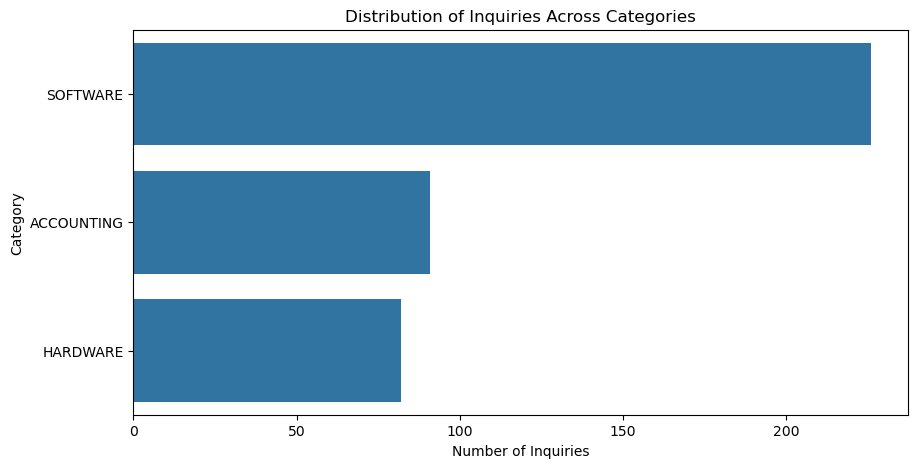

In [70]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 5))
sns.countplot(y='category', data=data, order=data['category'].value_counts().index)
plt.title('Distribution of Inquiries Across Categories')
plt.xlabel('Number of Inquiries')
plt.ylabel('Category')
plt.show()

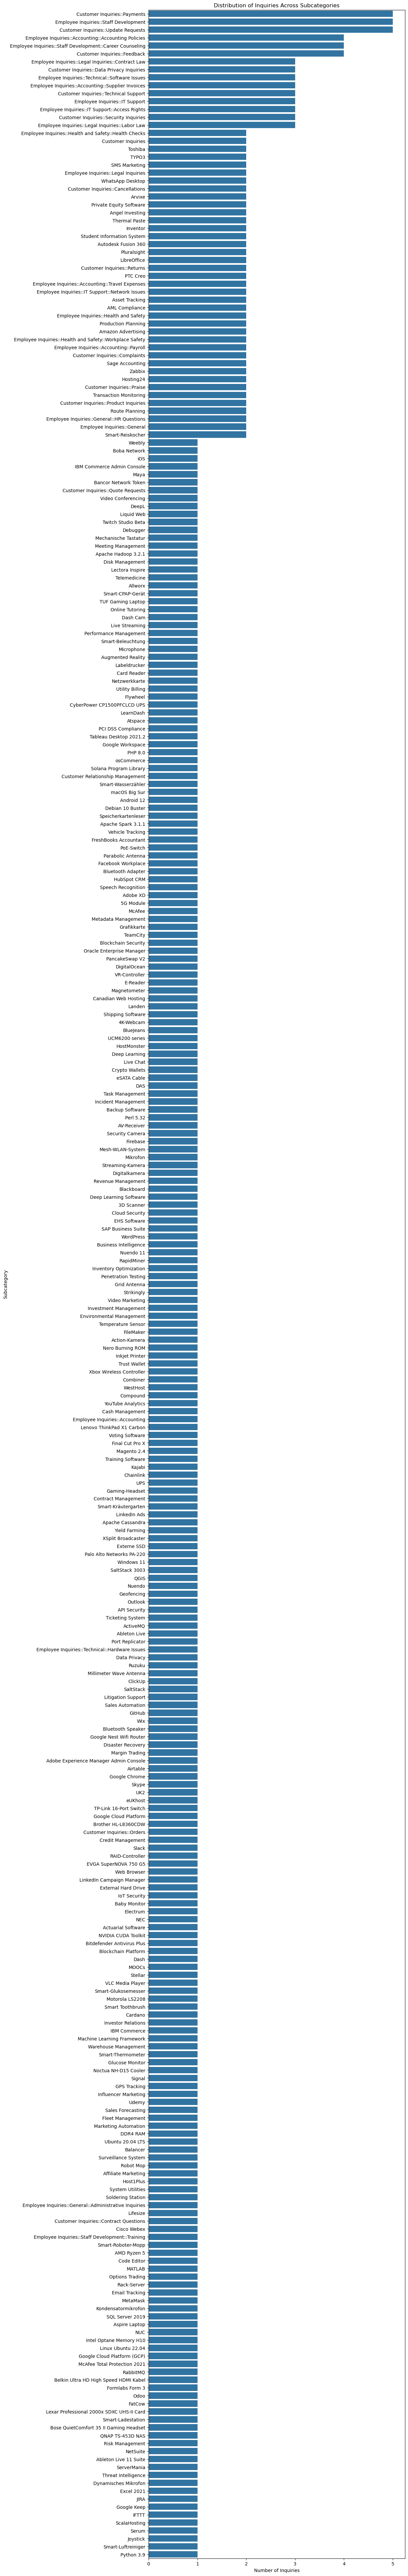

In [71]:
# Visualize the distribution of subcategories
plt.figure(figsize=(10, 100))
sns.countplot(y='subcategory', data=data, order=data['subcategory'].value_counts().index)
plt.title('Distribution of Inquiries Across Subcategories')
plt.xlabel('Number of Inquiries')
plt.ylabel('Subcategory')
plt.show()

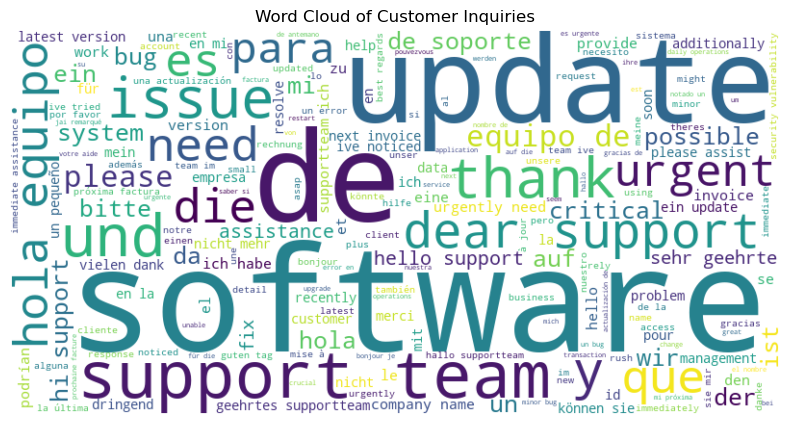

In [72]:
# Generate a word cloud for the processed inquiries
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['processed_inquiry']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Inquiries')
plt.show()

In [73]:
# Extract features and labels for both category and subcategory
X = data['processed_inquiry']
y_category = data['category']

In [74]:
# Split data into training and testing sets for category prediction
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_category, test_size=0.2, random_state=42)

In [75]:
# Define a pipeline for category prediction using LinearSVC
model_category_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [76]:
print(X_train_cat.isna().sum())
print(y_train_cat.isna().sum())

0
1


In [77]:
# Replace NaN values with empty strings
X_train_cat = X_train_cat.fillna('')
X_test_cat = X_test_cat.fillna('')

In [78]:
print(X_train_cat.isna().sum())
print(y_train_cat.isna().sum())

0
1


In [79]:
# Remove rows with NaN values from the features and target
X_train_cat = X_train_cat.dropna()
y_train_cat = y_train_cat[X_train_cat.index]

X_test_cat = X_test_cat.dropna()
y_test_cat = y_test_cat[X_test_cat.index]

In [80]:
print(X_train_cat.isna().sum())
print(y_train_cat.isna().sum())

0
1


In [81]:
# Identify the index of the row with NaN in y_train_cat
nan_index = y_train_cat.index[y_train_cat.isna()]

# Remove the rows with NaN values from both X_train_cat and y_train_cat
X_train_cat = X_train_cat.drop(index=nan_index)
y_train_cat = y_train_cat.drop(index=nan_index)

In [82]:
print(X_train_cat.isna().sum())
print(y_train_cat.isna().sum())

0
0


In [83]:
nan_index_test = y_test_cat.index[y_test_cat.isna()]
X_test_cat = X_test_cat.drop(index=nan_index_test)
y_test_cat = y_test_cat.drop(index=nan_index_test)

In [84]:
print(X_test_cat.isna().sum())
print(y_test_cat.isna().sum())

0
0


In [85]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [86]:
# Train the SVM category model
model_category_svm.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [87]:
# Predict and evaluate the SVM category model
preds_cat_svm = model_category_svm.predict(X_test_cat)
category_accuracy_svm = accuracy_score(y_test_cat, preds_cat_svm)
category_report_svm = classification_report(y_test_cat, preds_cat_svm)
print(f"Category Prediction Accuracy (SVM): {category_accuracy_svm}")
print("Category Classification Report (SVM):")
print(category_report_svm)

Category Prediction Accuracy (SVM): 0.625
Category Classification Report (SVM):
              precision    recall  f1-score   support

  ACCOUNTING       0.70      0.35      0.47        20
    HARDWARE       0.83      0.28      0.42        18
    SOFTWARE       0.59      0.90      0.72        42

    accuracy                           0.62        80
   macro avg       0.71      0.51      0.53        80
weighted avg       0.67      0.62      0.59        80



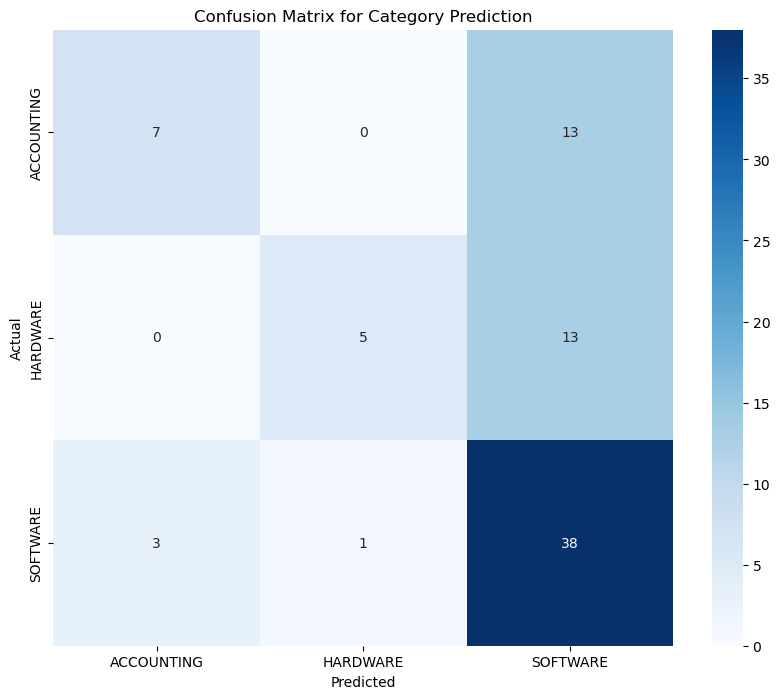

In [88]:
# Confusion matrix for category prediction
conf_matrix_cat = confusion_matrix(y_test_cat, preds_cat_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='Blues', xticklabels=model_category_svm.classes_, yticklabels=model_category_svm.classes_)
plt.title('Confusion Matrix for Category Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### END